### Pool of pH using MOCSY

Along with DIC, pH and TAlk profiles

RUN ON SALISH!

In [1]:
import cmocean as cmo
import sys
sys.path.append('/data/kramosmu/mocsy')
import mocsy
import matplotlib.gridspec as gspec
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import seaborn as sns
import seawater as sw
import xarray as xr
%matplotlib inline

import canyon_tools.metrics_tools as mpt
import canyon_tools.savitzky_golay as sg

In [2]:
RhoRef = 999.79998779
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density profile using a linear equation of state.
    
    INPUT:
    state: xarray dataframe
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be 1D arrays size nz
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [nz]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T) + beta*(S))
    return rho

def call_rho(t,state,zslice,xind,yind):
    RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds
    T = state.Temp.isel(T=t,Z=zslice,X=xind,Y=yind)
    S = state.S.isel(T=t,Z=zslice,X=xind,Y=yind)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho)

def get_vars(state, ptracer, mask, yind, xind, tslice=slice(8,20)):
    S =  np.ma.masked_array(np.nanmean(state.S[tslice,:,yind,xind], axis=0), mask=mask)
    T =  np.ma.masked_array(np.nanmean(state.Temp[tslice,:,yind,xind], axis=0), mask=mask)
    DIC_umolkg = np.ma.masked_array(np.nanmean(ptracer.Tr09[tslice,:,yind,xind], axis=0), mask=mask) #umol/kg
    TA_umolkg = np.ma.masked_array(np.nanmean(ptracer.Tr10[tslice,:,yind,xind], axis=0), mask=mask) #umol/kg
    density = np.ma.masked_array(calc_rho(RhoRef,T,S).data, mask=mask)
    DIC = (density*DIC_umolkg/1000)
    TA = (density*TA_umolkg/1000)
    return(DIC, TA, S, T)

def get_vars_3D(state, ptracer, mask, zslice, yslice, xslice, tslice=slice(8,20)):
    S =  np.ma.masked_array(np.nanmean(state.S[tslice,zslice,yslice,xslice], axis=0), mask=mask)
    T =  np.ma.masked_array(np.nanmean(state.Temp[tslice,zslice,yslice,xslice], axis=0), mask=mask)
    DIC_umolkg = np.ma.masked_array(np.nanmean(ptracer.Tr09[tslice,zslice,yslice,xslice], axis=0), mask=mask) #umol/kg
    TA_umolkg = np.ma.masked_array(np.nanmean(ptracer.Tr10[tslice,zslice,yslice,xslice], axis=0), mask=mask) #umol/kg
    density = np.ma.masked_array(calc_rho(RhoRef,T,S).data, mask=mask)
    DIC = (density*DIC_umolkg/1000)
    TA = (density*TA_umolkg/1000)
    return(DIC, TA, S, T)

def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*nz - BottomInd) # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=0.2, cmax=1.8):
    
    BAC = ConcFilt[yslice,xslice]
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.5,1.0],colors='k')
    plt.clabel(cs, fmt='%1.1f', fontsize=10)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

In [3]:
sns.set_context('talk')
sns.set_style('white')

# Get masks and open grid, state and tracer datasets
grid_file_A = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/gridGlob.nc' 
grid_file_Anoc = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/gridGlob.nc' 

ptrARGO = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/ptracersGlob.nc')
ptrARGOnoc = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/ptracersGlob.nc')
stateARGO = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/03_Ast03_Argo/stateGlob.nc')
stateARGOnoc = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo/stateGlob.nc')
gridARGO = xr.open_dataset(grid_file_A)
gridARGOnoc = xr.open_dataset(grid_file_Anoc)

with nc.Dataset(grid_file_A, 'r') as nbl:
    hFacA = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    DepthA = nbl.variables['Depth'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    
with nc.Dataset(grid_file_Anoc, 'r') as nbl:
    hFacAnoc = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacAnoc, 0)
    maskCAnoc = np.ma.getmask(hfac)
    rAAnoc = nbl.variables['rA'][:]
    DepthAnoc = nbl.variables['Depth'][:]

grid_file_B = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/gridGlob.nc' 
grid_file_Bnoc = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/gridGlob.nc' 
ptrPATH = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/ptracersGlob.nc')
ptrPATHnoc = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/ptracersGlob.nc')
statePATH = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/03_Bar03_Path/stateGlob.nc')
statePATHnoc = xr.open_dataset('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path/stateGlob.nc')
gridPATH = xr.open_dataset(grid_file_B)
gridPATHnoc = xr.open_dataset(grid_file_Bnoc)

with nc.Dataset(grid_file_B, 'r') as nbl:
    hFacB = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    DepthB = nbl.variables['Depth'][:]
with nc.Dataset(grid_file_Bnoc, 'r') as nbl:
    hFacBnoc = nbl.variables['HFacC'][:]
    hfac = np.ma.masked_values(hFacBnoc, 0)
    maskCBnoc = np.ma.getmask(hfac)
    rABnoc = nbl.variables['rA'][:]
    DepthBnoc = nbl.variables['Depth'][:]

In [4]:
# Stations x, y indices A for ARGO, B for Pathways
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

linestyles = ['-','--',':','-.']
st_names=['S1','S2','S3','S4']

Initial pH at Astoria sb is 7.800396 
Initial pH at Barkley sb is 7.739975 


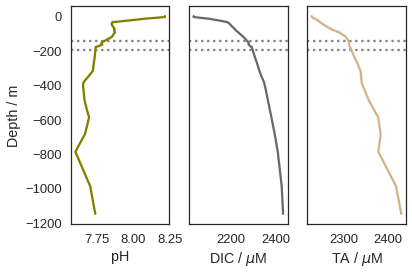

In [14]:
# Make profiles at stations S1, S2, S3, S4, MASKED USING NO-CANYON HFACC
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(6,4))
colors = ['dimgray', 'tan', 'olive']

stx = 180
sty = 50

for ax in [ax0,ax1,ax2]:
    ax.axhline(gridARGO.Z[29], color='0.5', linestyle=':') #Ast sb
    ax.axhline(gridARGO.Z[39], color='0.5', linestyle=':') #Bar sb

DICini, TAini, Sini, Tini = get_vars(stateARGO,ptrARGO,maskCA[:,sty,stx], sty, stx, tslice=slice(0,1))
depthini = np.ma.masked_array(gridARGO.Z[:], mask=maskCA[:,sty,stx])
Surf_pini = np.ones_like(DICini)
zeroini  = np.zeros_like(DICini)

response_ini = mocsy.mvars(temp=Tini, sal=Sini, alk=TAini, dic=DICini, 
                           sil=zeroini, phos=zeroini, patm=Surf_pini, depth=depthini, lat=zeroini, 
                           optcon='mol/m3', optt='Tinsitu', optp='m',
                           optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pHini,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_ini
    
ax0.plot(pHini[:-2],gridARGO.Z[:-2], color=colors[2])
ax1.plot(DICini[:-2],gridARGO.Z[:-2], color=colors[0])
ax2.plot(TAini[:-2],gridARGO.Z[:-2], color=colors[1])
print('Initial pH at Astoria sb is %f ' %(pHini[29]))    
print('Initial pH at Barkley sb is %f ' %(pHini[39]))    

for ax in [ax1,ax2]:
    ax.set_yticks([])

ax0.set_ylabel('Depth / m')
ax0.set_xlabel('pH')
ax1.set_xlabel('DIC / $\mu$M')
ax2.set_xlabel('TA / $\mu$M')

fig.savefig('07e_ini_profiles_pH.pdf',format='pdf', bbox_inches='tight')


min pH anom at -102.500000 m of S1 is -0.101641 
min pH anom at -87.500000 m of S2 is -0.065785 
min pH anom at -92.500000 m of S3 is -0.033192 
min pH anom at -137.500000 m of S4 is -0.017738 


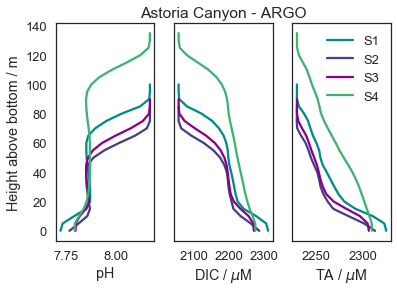

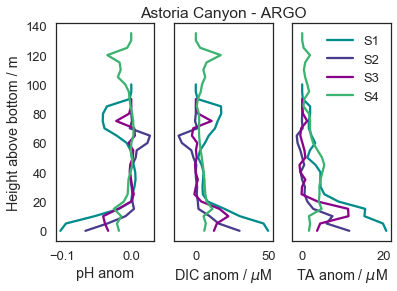

In [14]:
# Make profiles at stations S1, S2, S3, S4, MASKED USING NO-CANYON HFACC
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(6,4))
fig2, (ax3,ax4,ax5) = plt.subplots(1,3, figsize=(6,4))
colors = ['darkcyan','darkslateblue','darkmagenta','mediumseagreen']

for xind, yind, st, col in zip(xindA, yindA, st_names, colors):
    
    DIC, TA, S, T = get_vars(stateARGO,ptrARGO,maskCA[:,yind,xind], yind, xind)
    DIC_noc, TA_noc, S_noc, T_noc = get_vars(stateARGOnoc,ptrARGOnoc,maskCAnoc[:,yind,xind], yind, xind)
    
    depth = np.ma.masked_array(gridARGO.Z[:], mask=maskCA[:,yind,xind])
    depth_noc = np.ma.masked_array(gridARGOnoc.Z[:], mask=maskCAnoc[:,yind,xind])
    
    Surf_p = np.ones_like(DIC)
    zero  = np.zeros_like(DIC)
    
    response_tup = mocsy.mvars(temp=T, sal=S, alk=TA, dic=DIC, 
                               sil=zero, phos=zero, patm=Surf_p, depth=depth, lat=zero, 
                               optcon='mol/m3', optt='Tinsitu', optp='m',
                               optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    response_tup_noc = mocsy.mvars(temp=T_noc, sal=S_noc, alk=TA_noc, dic=DIC_noc, 
                                   sil=zero, phos=zero, patm=Surf_p, depth=depth_noc, lat=zero, 
                                   optcon='mol/m3', optt='Tinsitu', optp='m',
                                   optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH_noc,pco2_noc,fco2_noc,co2_noc,hco3_noc,co3_noc,OmegaA_noc,OmegaC_noc,BetaD_noc,DENis_noc,p_noc,Tis_noc = \
    response_tup_noc
    
    pH_anom = pH-pH_noc
    DIC_anom = DIC-DIC_noc
    TA_anom = TA-TA_noc
    
    ax0.plot(pH,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax1.plot(DIC,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax2.plot(TA,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax3.plot(pH_anom,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax4.plot(DIC_anom,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax5.plot(TA_anom,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    
    ind_min = np.max(np.argwhere(depth_noc!=np.nan))
    print('min pH anom at %f m of %s is %f ' %(depth[ind_min],st,pH_anom[ind_min]))    

for ax in [ax1,ax2,ax4,ax5]:
    ax.set_yticks([])
ax0.set_ylabel('Height above bottom / m')
ax0.set_xlabel('pH')
ax1.set_xlabel('DIC / $\mu$M')
ax2.set_xlabel('TA / $\mu$M')
ax3.set_ylabel('Height above bottom / m')
ax3.set_xlabel('pH anom')
ax4.set_xlabel('DIC anom / $\mu$M')
ax5.set_xlabel('TA anom / $\mu$M')
ax1.set_title('Astoria Canyon - ARGO')
ax4.set_title('Astoria Canyon - ARGO')
ax5.legend(loc=0)
ax2.legend(loc=0)

fig.savefig('07a_profiles_pH_ARGO.pdf',format='pdf', bbox_inches='tight')
fig2.savefig('07b_profiles_pHanom_ARGO.pdf',format='pdf', bbox_inches='tight')

min pH anom at -102.500000 m of S1 is -0.004455 
min pH anom at -77.500000 m of S2 is -0.000077 
min pH anom at -87.500000 m of S3 is -0.003312 
min pH anom at -172.500000 m of S4 is -0.009057 


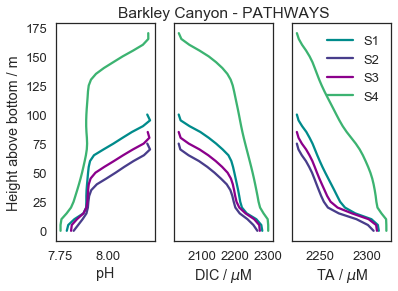

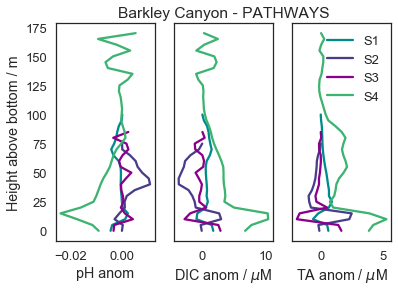

In [18]:
# Make profiles at stations S1, S2, S3, S4, MASKED USING NO-CANYON HFACC

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(6,4))
fig2, (ax3,ax4,ax5) = plt.subplots(1,3, figsize=(6,4))
colors = ['darkcyan','darkslateblue','darkmagenta','mediumseagreen']

for xind, yind, st, col in zip(xindA, yindA, st_names, colors):
    
    DIC, TA, S, T = get_vars(statePATH,ptrPATH,maskCBnoc[:,yind,xind], yind, xind)
    DIC_noc, TA_noc, S_noc, T_noc = get_vars(statePATHnoc,ptrPATHnoc,maskCBnoc[:,yind,xind], yind, xind)
    
    depth = np.ma.masked_array(gridPATH.Z[:], mask=maskCB[:,yind,xind])
    depth_noc = np.ma.masked_array(gridPATHnoc.Z[:], mask=maskCBnoc[:,yind,xind])
    
    Surf_p = np.ones_like(DIC)
    zero  = np.zeros_like(DIC)
    
    response_tup = mocsy.mvars(temp=T, sal=S, alk=TA, dic=DIC, 
                               sil=zero, phos=zero, patm=Surf_p, depth=depth_noc, lat=zero, 
                               optcon='mol/m3', optt='Tinsitu', optp='m',
                               optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    response_tup_noc = mocsy.mvars(temp=T_noc, sal=S_noc, alk=TA_noc, dic=DIC_noc, 
                                   sil=zero, phos=zero, patm=Surf_p, depth=depth_noc, lat=zero, 
                                   optcon='mol/m3', optt='Tinsitu', optp='m',
                                   optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH_noc,pco2_noc,fco2_noc,co2_noc,hco3_noc,co3_noc,OmegaA_noc,OmegaC_noc,BetaD_noc,DENis_noc,p_noc,Tis_noc = \
    response_tup_noc
    
    pH_anom = pH-pH_noc
    DIC_anom = DIC-DIC_noc
    TA_anom = TA-TA_noc
    
    ax0.plot(pH,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax1.plot(DIC,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax2.plot(TA,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax3.plot(pH_anom,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax4.plot(DIC_anom,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    ax5.plot(TA_anom,depth_noc-np.nanmin(depth_noc), label=st, color=col)
    
    ind_min = np.max(np.argwhere(depth_noc!=np.nan))
    print('min pH anom at %f m of %s is %f ' %(depth[ind_min],st,pH_anom[ind_min]))    

for ax in [ax1,ax2,ax4,ax5]:
    ax.set_yticks([])
ax0.set_ylabel('Height above bottom / m')
ax0.set_xlabel('pH')
ax1.set_xlabel('DIC / $\mu$M')
ax2.set_xlabel('TA / $\mu$M')
ax3.set_ylabel('Height above bottom / m')
ax3.set_xlabel('pH anom')
ax4.set_xlabel('DIC anom / $\mu$M')
ax5.set_xlabel('TA anom / $\mu$M')
ax1.set_title('Barkley Canyon - PATHWAYS')
ax4.set_title('Barkley Canyon - PATHWAYS')
ax5.legend(loc=0)
ax2.legend(loc=0)

fig.savefig('07c_profiles_pH_PATH.pdf',format='pdf', bbox_inches='tight')
fig2.savefig('07d_profiles_pHanom_ARGO.pdf',format='pdf', bbox_inches='tight')

### pool of pH

In [15]:
xslice = slice(0,616)
yslice = slice(0,360)
zslice = slice(0,104)
nz = 104

DICpool, TApool, Spool, Tpool = get_vars_3D(stateARGO,ptrARGO,maskCA[zslice,yslice,xslice],zslice,yslice,xslice)

depth_ast = np.expand_dims(np.expand_dims(gridARGO.Z[zslice],1),1)
depth_ast = np.ma.masked_array(depth_ast+np.zeros_like(maskCA[zslice,yslice,xslice]),
                               mask=maskCA[zslice,yslice,xslice])
    
Surf_p = np.ones_like(DICpool.ravel(order='F'))
zero  = np.zeros_like(DICpool.ravel(order='F'))
    
response_tup = mocsy.mvars(temp=Tpool.ravel(order='F'), sal=Spool.ravel(order='F'), alk=TApool.ravel(order='F'), 
                           dic=DICpool.ravel(order='F'), 
                           sil=zero, phos=zero, patm=Surf_p, depth=depth_ast.ravel(order='F'), lat=zero, 
                           optcon='mol/m3', optt='Tinsitu', optp='m',
                           optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH_ast,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

In [16]:
DICpool, TApool, Spool, Tpool = get_vars_3D(statePATH,ptrPATH,maskCB[zslice,yslice,xslice],zslice,yslice,xslice)

depth_bar = np.expand_dims(np.expand_dims(gridARGO.Z[zslice],1),1)
depth_bar = np.ma.masked_array(depth_bar+np.zeros_like(maskCB[zslice,yslice,xslice]),
                               mask=maskCB[zslice,yslice,xslice])
    
Surf_p = np.ones_like(DICpool.ravel(order='F'))
zero  = np.zeros_like(DICpool.ravel(order='F'))
    
response_tup = mocsy.mvars(temp=Tpool.ravel(order='F'), sal=Spool.ravel(order='F'), alk=TApool.ravel(order='F'), 
                           dic=DICpool.ravel(order='F'), 
                           sil=zero, phos=zero, patm=Surf_p, depth=depth_bar.ravel(order='F'), lat=zero, 
                           optcon='mol/m3', optt='Tinsitu', optp='m',
                           optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

pH_bar,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

In [17]:
ConcAreaLin,pH_bott_ast,AreaTr = BottomConc(pH_ast.reshape(np.shape(maskCA[zslice,yslice,xslice]), order='F'),
                                              hFacA[zslice,yslice,xslice],  rAA[yslice,xslice],
                                              DepthA[yslice,xslice],nz-1, sbdepth=-152.5 )
ConcAreaLin,pH_bott_bar,AreaTr = BottomConc(pH_bar.reshape(np.shape(maskCB[zslice,yslice,xslice]), order='F'),
                                              hFacB[zslice,yslice,xslice],  rAB[yslice,xslice],
                                              DepthB[yslice,xslice],nz-1, sbdepth=-200.0 )

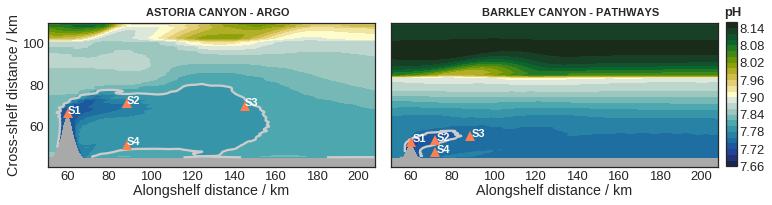

In [83]:
sns.set_style('white')
sns.set_context('talk')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(12,5))

gs = gspec.GridSpec(1, 2, hspace=0.05,wspace=0.05)

ax0 = plt.subplot(gs[0])
ax4 = plt.subplot(gs[1])

yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

BAC = pH_bott_ast[yslice_pl,xslice_pl]
levels = np.arange(7.66,8.18,0.02)
mesh = ax0.contourf(X[xslice_pl]/1000,Y[yslice_pl]/1000,BAC,levels, cmap=cmo.cm.delta)
CS = ax0.contour(X[xslice_pl]/1000,Y[yslice_pl]/1000,BAC,[7.80], colors='0.8')    

ax0.tick_params(axis='x', pad=1)
ax0.tick_params(axis='y', pad=1)
ax0.set_aspect(1)

BAC2 = pH_bott_bar[yslice_pl,xslice_pl]
mesh2 = ax4.contourf(X[xslice_pl]/1000,Y[yslice_pl]/1000,BAC2,levels, cmap=cmo.cm.delta)
CS2 = ax4.contour(X[xslice_pl]/1000,Y[yslice_pl]/1000,BAC2,[7.74], colors='0.8')    
   
ax0.tick_params(axis='x', pad=1)
ax0.tick_params(axis='y', pad=1)
ax0.set_aspect(1)
ax4.set_aspect(1)

ax0.set_facecolor("darkgrey")
ax4.set_facecolor("darkgrey")

ax4.yaxis.set_ticks([])
ax0.set_ylabel('Cross-shelf distance / km', labelpad=1)
ax0.set_xlabel('Alongshelf distance / km', labelpad=1)
ax4.set_xlabel('Alongshelf distance / km', labelpad=1)

cbar_ax = fig.add_axes([0.91, 0.305, 0.013, 0.4])
cb=fig.colorbar(mesh2, cax=cbar_ax,
                format='%1.2f')
cb.ax.yaxis.set_tick_params(pad=2)
ax0.xaxis.set_tick_params(pad=4)
ax0.yaxis.set_tick_params(pad=4)
ax4.xaxis.set_tick_params(pad=4)

ax0.text(0.3,1.05,'ASTORIA CANYON - ARGO',fontweight='bold',transform=ax0.transAxes)
ax4.text(0.28,1.05,'BARKLEY CANYON - PATHWAYS',fontweight='bold',transform=ax4.transAxes)
ax4.text(1.02,1.05,'pH',fontweight='bold',transform=ax4.transAxes, fontsize=13)

for ii in range(len(xindA)):
    ax0.plot(X[xindA[ii]]/1000,Y[yindA[ii]]/1000,'^', color='coral')
    ax4.plot(X[xindB[ii]]/1000,Y[yindB[ii]]/1000,'^', color='coral')
    ax0.text(X[xindA[ii]]/1000,Y[yindA[ii]]/1000,st_names[ii], fontweight='bold', color='W')
    ax4.text(X[xindB[ii]]/1000+1,Y[yindB[ii]]/1000+0,st_names[ii], fontweight='bold', color='w')
plt.savefig('08_pH_pool.pdf',format='pdf', bbox_inches='tight')    